# Tutorials on Brian

In [1]:
from brian2 import *
%matplotlib inline

### Unit system
* Each constant requires a unit: 10*ms, 100*volt
* you can specify the size or not (volt, mV...both are fine)
* you can not specify 2*volt + 3*A

### Base model
for diff equations:
the end of a line you write *{: unit}* where unit is the SI unit of that variable. 

In [2]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

In [3]:
# Create a neuron
G = NeuronGroup(1, eqs)

first two arguments when you create one of these objects are the number of neurons (in this case, 1) and the defining differential equations.

* all variables have to be present in diff equations
* start scope at the top of the cell - make sure that any Brian objects created before the function is called aren’t included in the next run of the simulation

In [4]:
print('Before v = %s' % G.v[0])
run(100*ms)
print('After v = %s' % G.v[0])

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.02s). [brian2.stateupdaters.base.method_choice]


Before v = 0.0
After v = 0.9999546000702376


In [5]:
# Verify the value
print('Expected value of v = %s' % (1-exp(-100*ms/tau)))

Expected value of v = 0.9999546000702375


### New simulation (run) + vizualization

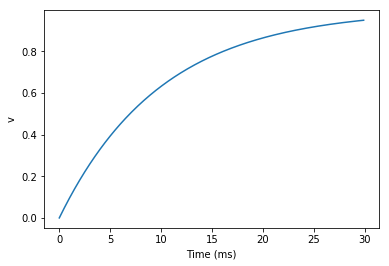

In [6]:
start_scope()

G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, ['v', 'i'], record=True)

run(30*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

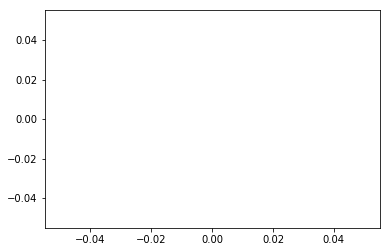

In [7]:
plot(M.i);

### Add Analytical solution

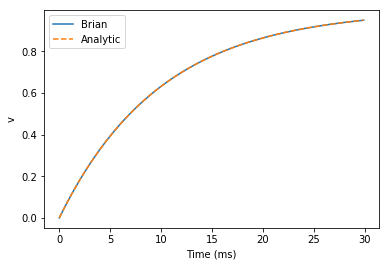

In [8]:
start_scope()

G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, 'v', record=0)

run(30*ms)

plot(M.t/ms, M.v[0], 'C0', label='Brian')
plot(M.t/ms, 1-exp(-M.t/tau), 'C1--',label='Analytic')
xlabel('Time (ms)')
ylabel('v')
legend();

### Play with parameters

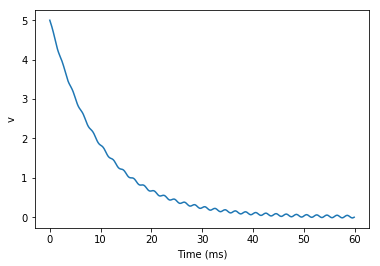

In [9]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (cos(2*pi*500*Hz*t)-v)/tau : 1
'''

# Change to Euler method because exact integrator doesn't work here
G = NeuronGroup(1, eqs, method='euler')
M = StateMonitor(G, 'v', record=0)

G.v = 5 # initial value

run(60*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

## Adding spikes
added two new keywords to the NeuronGroup declaration:
* threshold='v>0.8' 
* reset='v = 0'

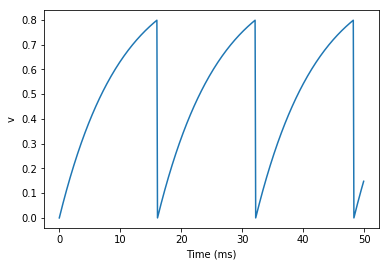

In [10]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

M = StateMonitor(G, 'v', record=0)
run(50*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

In [11]:
G.events['spike']

'v>0.8'

### Internaly Brian has recorded the spikes, let's visualize them

In [12]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

spikemon = SpikeMonitor(G)

run(50*ms)
    
print('Spike times: %s' % spikemon.t[:])

Spike times: [16.  32.1 48.2] ms


In [13]:
# plt.scatter(spikemon.t[:],M.t/ms)
# print(spikemon.t[:])
# print(M.t/ms)

#### Now show them both same time

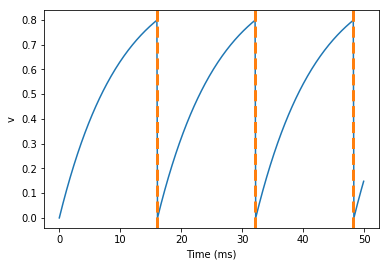

In [14]:
start_scope()



G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('v');

## Refractoriness
after the neuron fires a spike it becomes refractory for a certain duration and cannot fire another spike until this period is over

* add refractory=1*ms to the NeuronGroup
* (unless refractory) !

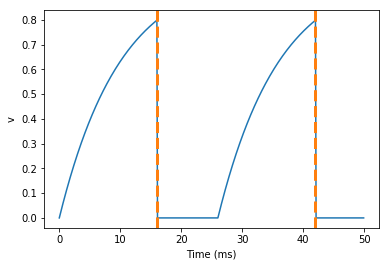

In [15]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=10*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('v');

#### Example:
* increase refractory
* decrease tau
* no "unless refractory"

Spike times: [ 8. 23. 38.] ms


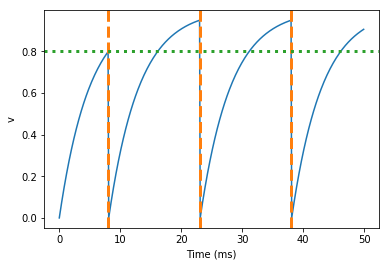

In [16]:
start_scope()

tau = 5*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=15*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
axhline(0.8, ls=':', c='C2', lw=3)
xlabel('Time (ms)')
ylabel('v')
print("Spike times: %s" % spikemon.t[:])

The behaviour for the first spike is the same: v rises to 0.8 and then the neuron fires a spike at time 8 ms before immediately resetting to 0. Since the refractory period is now 15 ms this means that the neuron won’t be able to spike again until time 8 + 15 = 23 ms. Immediately after the first spike, the value of v now instantly starts to rise because we didn’t specify (unless refractory) in the definition of dv/dt. However, once it reaches the value 0.8 (the dashed green line) at time roughly 8 ms it doesn’t fire a spike even though the threshold is v>0.8. This is because the neuron is still refractory until time 23 ms, at which point it fires a spike.

## Multiple Neurons
Same policy as up until now, except now we additionally have N=100 neurons inputed into the NeuronGroup

This causes few changes:
    * multiple neurons
    * * G.v=rand()* initializes the neurons with random weights

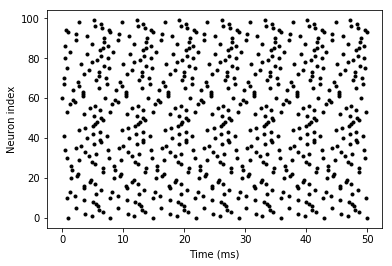

In [17]:
start_scope()

N = 100
tau = 10*ms
eqs = '''
dv/dt = (2-v)/tau : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact')
G.v = 'rand()'

spikemon = SpikeMonitor(G)

run(50*ms)

plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

## Parameters

* v0 : 1 add parameter per neuron 


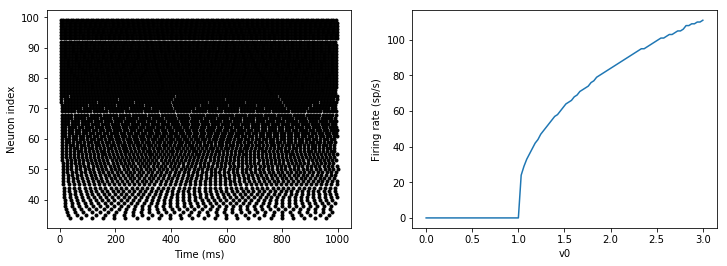

In [18]:
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms

eqs = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
M = SpikeMonitor(G)
M1 = StateMonitor(G, 'v', record=[0,1,2,44])

G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

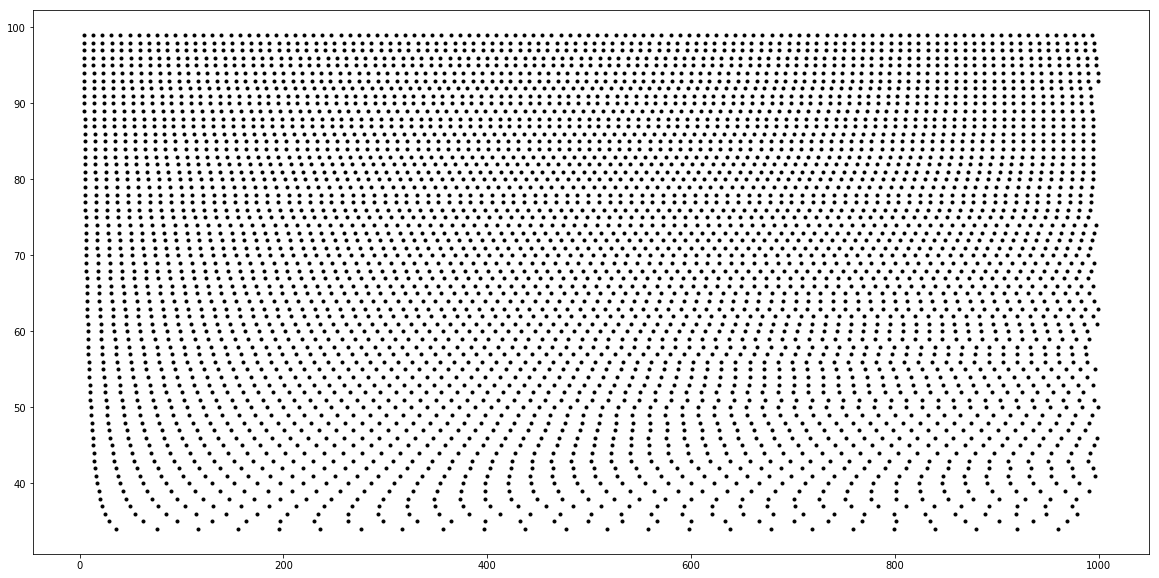

In [19]:
# plot(M.t/ms, M.i, '.k');
plt.figure(figsize=(20, 10))

plot(M.t/ms, M.i, '.k');

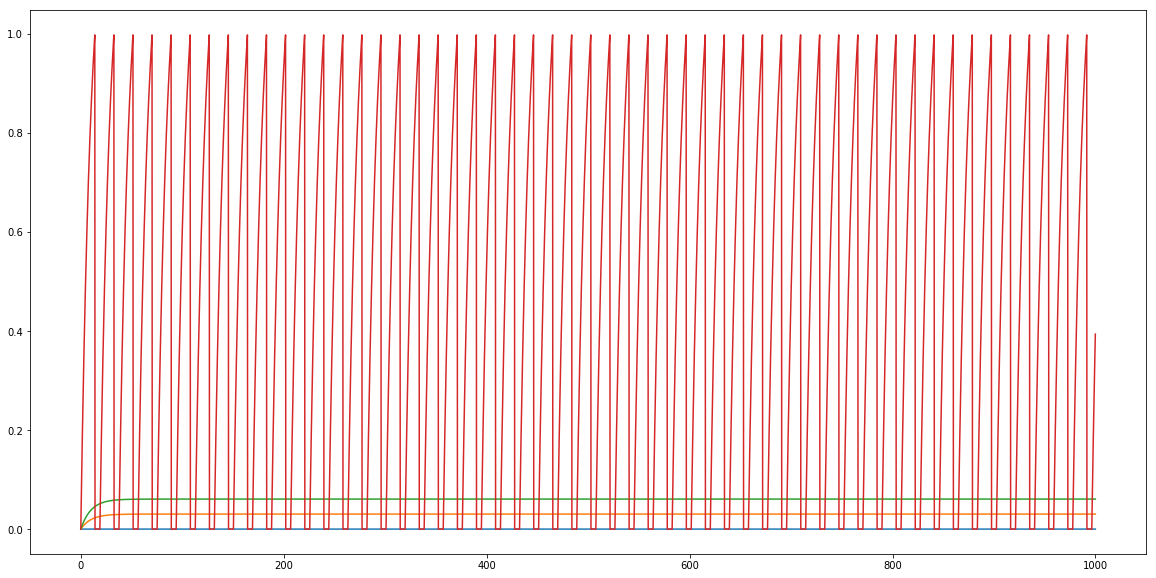

In [20]:
plt.figure(figsize=(20,10))
plt.plot(M1.t/ms, M1.v[0]);
plt.plot(M1.t/ms, M1.v[1]);
plt.plot(M1.t/ms, M1.v[2]);
plt.plot(M1.t/ms, M1.v[3]);

## Stochastic neurons
* adding noise by using *x1* symbol in the differential equations 
* We do have to take into account the way stochastic differentials scale with time, which is why we multiply it by *tau**-0.5*

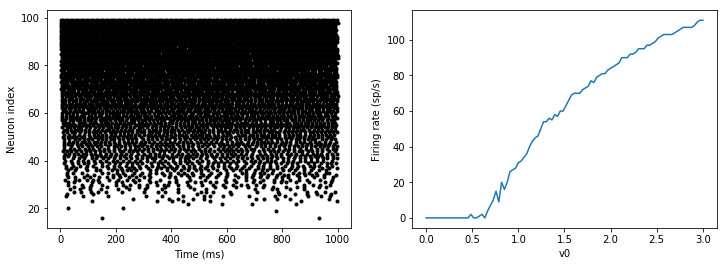

In [21]:
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms
sigma = 0.2

eqs = '''
dv/dt = (v0-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
v0 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='euler')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

## PSTH

In [22]:
start_scope()

N = 1000
tau = 10*ms
vr = -70*mV
vt0 = -50*mV
delta_vt0 = 5*mV
tau_t = 100*ms
sigma = 0.5*(vt0-vr)
v_drive = 2*(vt0-vr)
duration = 100*ms

eqs = '''
dv/dt = (v_drive+vr-v)/tau + sigma*xi*tau**-0.5 : volt
dvt/dt = (vt0-vt)/tau_t : volt
'''

reset = '''
v = vr
vt += delta_vt0
'''

G = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')
spikemon = SpikeMonitor(G)
statemon = StateMonitor(G, 'v', record=np.array((0,10)))

G.v = 'rand()*(vt0-vr)+vr'
G.vt = vt0

run(duration)

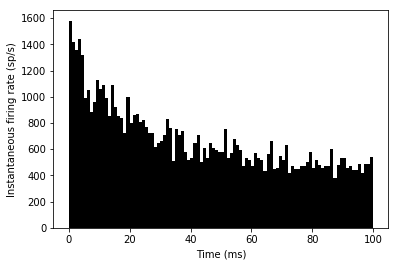

In [23]:
_ = hist(spikemon.t/ms, 100, histtype='stepfilled', facecolor='k', weights=ones(len(spikemon))/(N*defaultclock.dt))
xlabel('Time (ms)')
ylabel('Instantaneous firing rate (sp/s)');

In [24]:
np.shape(statemon.v)

(2, 1000)

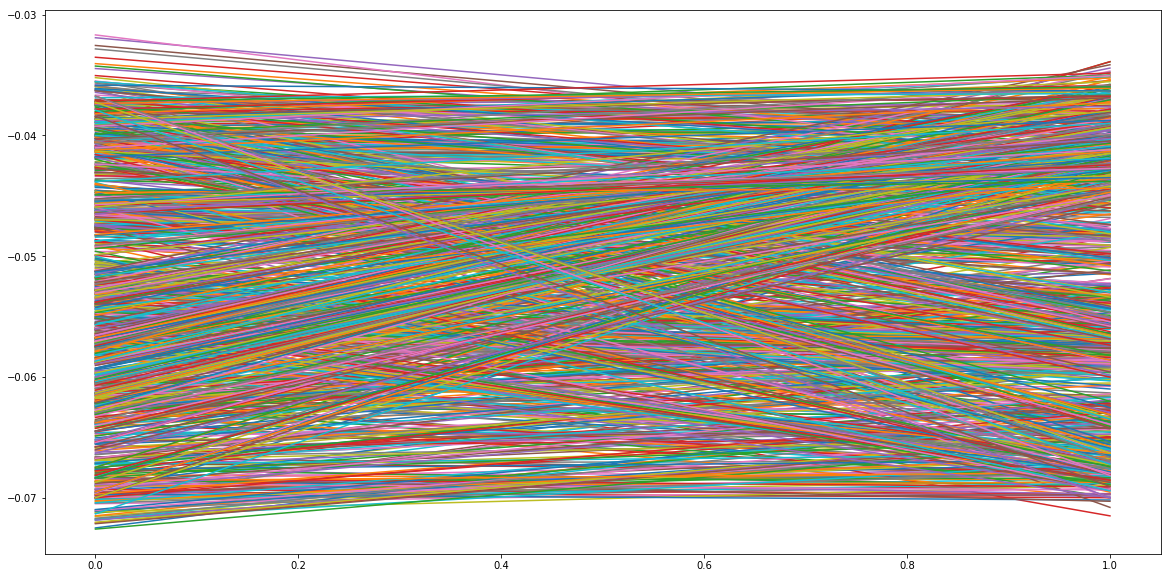

In [25]:
plt.figure(figsize=(20,10))
plt.plot(statemon.v);

# Tutorial 2: Synapses

## The simplest Synapse

In [26]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 20]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)
S1 = Synapses(G, G, on_pre='v_post -= 0.2')
S1.connect(i=1, j=2)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

WARNING    "tau" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


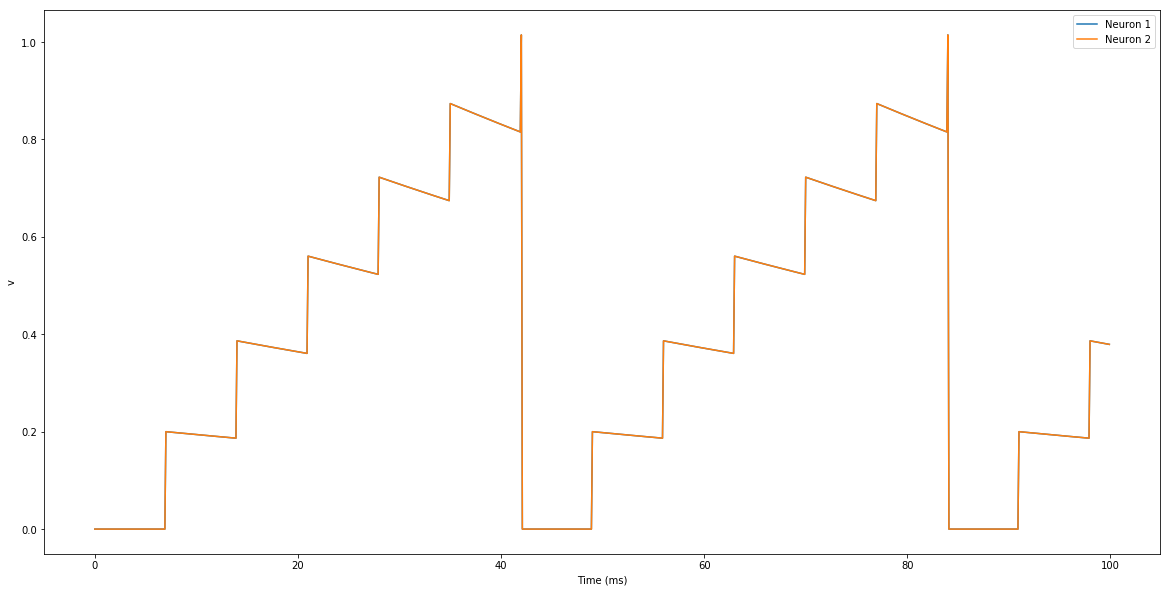

In [27]:
plt.figure(figsize=(20,10))

# plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[1], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

## Add a weight as a Function
* w : 1 defines a single dimension parameter w
* for each neuron separetely 


WARNING    "tau" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


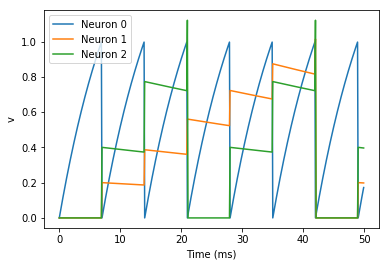

In [28]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

##  Introducing a delay
Make it react to the spike with a delay
Synapse add option:

* S.delay = 'j /* 2 * ms'

WARNING    "tau" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


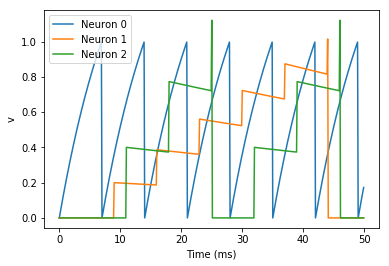

In [29]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'
S.delay = 'j*2*ms'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

## Mor complex connectivity 
* when you can have a big network -> you don't specify the connectivity explicitly
* instead we specify a condition

In [30]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2)

S.connect(condition='i!=j', p=0.2) 
* connect all i and j as long as i! = j


### Visualize the Connectivity

In [31]:
def visualise_connectivity(S):
    # load sources and targets
    Ns = len(S.source)
    Nt = len(S.target)
   
    figure(figsize=(10, 4))
    
    subplot(121)
    
    # plot points in srcs and targets
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    
    # zip the indicies and then connect them
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    
    subplot(122)
    plot(S.i, S.j, 'ok')
    
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

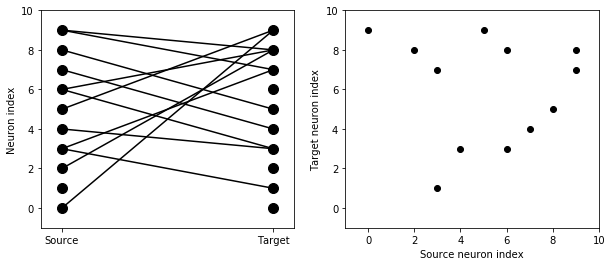

In [32]:
visualise_connectivity(S)

* left plot: vertical connectivity from src to target neuron
* right plot: each dot is a synapse x src and y target

### Change the proabilities and vizualize again

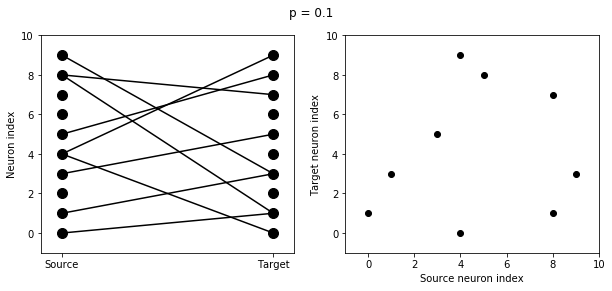

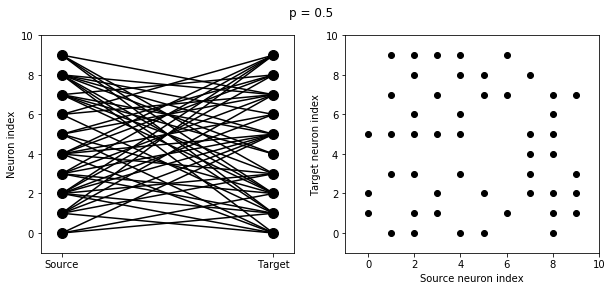

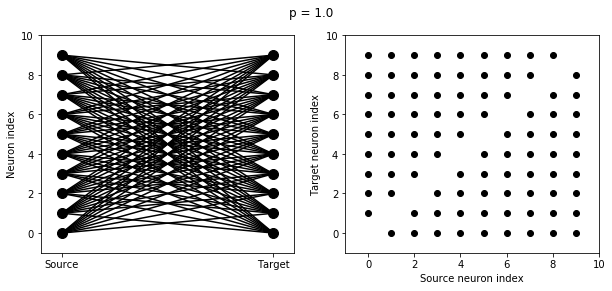

In [33]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

for p in [0.1, 0.5, 1.0]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('p = '+str(p))

### Only connect neighbouring neurons

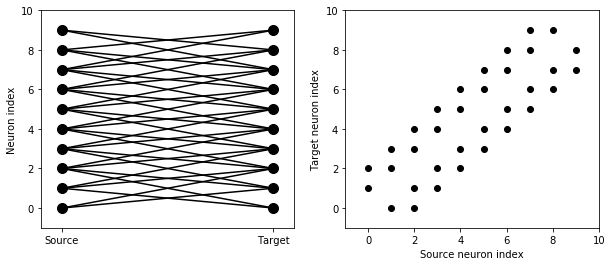

In [34]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(condition='abs(i-j)<3 and i!=j')
visualise_connectivity(S)


### There is also generator syntax to create connections
* for large networks you can also directly specify which neurons should be connected to which
* you can put a string defined function inside of it

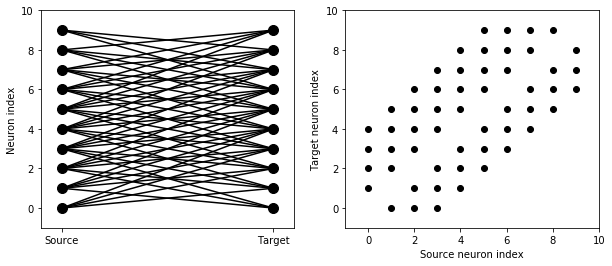

In [35]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(j='k for k in range(i-3, i+5) if i!=k', skip_if_invalid=True)
visualise_connectivity(S)


### One to one connection

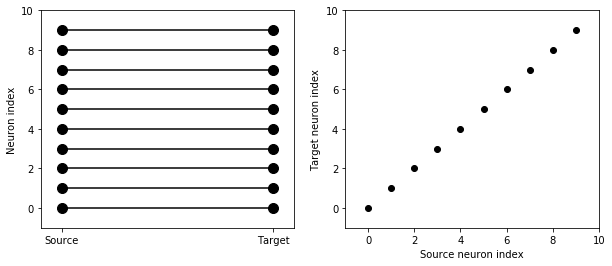

In [36]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(j='i')
visualise_connectivity(S)

## Distance dependant function
* you can also specify the values through a string 


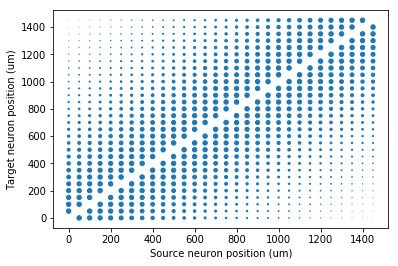

In [37]:
start_scope()

N = 30
neuron_spacing = 50*umetre
width = N/4.0*neuron_spacing

# Neuron has one variable x, its position
G = NeuronGroup(N, 'x : metre')
G.x = 'i*neuron_spacing'

# All synapses are connected (excluding self-connections)
S = Synapses(G, G, 'w : 1')
S.connect(condition='i!=j')
# Weight varies with distance
S.w = 'exp(-(x_pre-x_post)**2/(2*width**2))'

scatter(S.x_pre/um, S.x_post/um, S.w*20)
xlabel('Source neuron position (um)')
ylabel('Target neuron position (um)');

## STDP
spike-timing dependent plasticity 

### How it's done:
* we don't want to sum over all pairs of spikes
* also that is physiologically implausible, neuron would have to remeber all the spikes that ever happened

Instead:
* define two variables $a_{pre}$ and $a_{post}$ - traces of the synaptic activity 
* we update them whenever the activity occurs
* on each event, update the weight

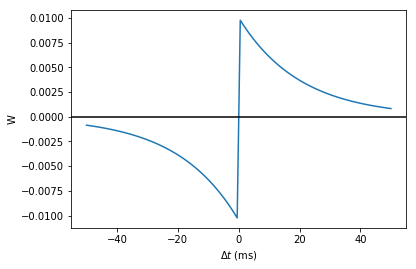

In [38]:
tau_pre = tau_post = 20*ms
A_pre = 0.01
A_post = -A_pre*1.05
delta_t = linspace(-50, 50, 100)*ms
W = where(delta_t>0, A_pre*exp(-delta_t/tau_pre), A_post*exp(delta_t/tau_post))
plot(delta_t/ms, W)
xlabel(r'$\Delta t$ (ms)')
ylabel('W')
axhline(0, ls='-', c='k');

### With redefined formulation now transform to Brian code:
* use of multiline string, to define the synaptic variables 
* $(event-driven)$ after the definitions of apre and apost - only update on an event
* $clip$ specifies the ranges of the weight

WARNING    "t" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 38. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


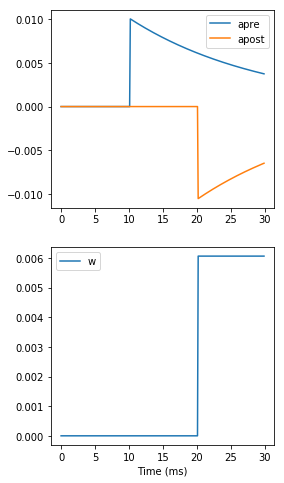

In [39]:
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(2, 'v:1', threshold='t>(1+i)*10*ms', refractory=100*ms)

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''', method='linear')
S.connect(i=0, j=1)
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)
M1 = StateMonitor(G, ['v', 'i'], record=True)

run(30*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Time (ms)');

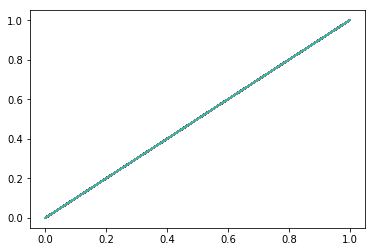

In [40]:
plot(M1.i);

Finally, let’s verify that this formulation is equivalent to the original one.

WARNING    "t" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 38. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "t" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value 38. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "t" is an internal variable of group "synapses", but also exists in the run namespace with the value 38. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


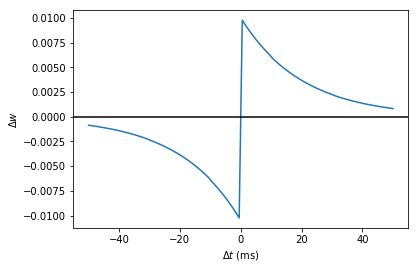

In [41]:
start_scope()

taupre = taupost = 20*ms
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
tmax = 50*ms
N = 100

# Presynaptic neurons G spike at times from 0 to tmax
# Postsynaptic neurons G spike at times from tmax to 0
# So difference in spike times will vary from -tmax to +tmax
G = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
H = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
G.tspike = 'i*tmax/(N-1)'
H.tspike = '(N-1-i)*tmax/(N-1)'

S = Synapses(G, H,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             apre += Apre
             w = w+apost
             ''',
             on_post='''
             apost += Apost
             w = w+apre
             ''')
S.connect(j='i')

run(tmax+1*ms)

plot((H.tspike-G.tspike)/ms, S.w)
xlabel(r'$\Delta t$ (ms)')
ylabel(r'$\Delta w$')
axhline(0, ls='-', c='k');

# Tutorial 3: Simulations